# Importing libraries

In [221]:
# data
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# plotting/visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='white', rc={'axes.facecolor': (0,0,0,0)})

# text processing
import re
import nltk
from nltk.corpus import stopwords

# language detection
import langdetect

# tokenizing
from nltk.tokenize import sent_tokenize, word_tokenize

# lemmatizing
from nltk.stem import WordNetLemmatizer

# sentiment
from nltk.sentiment import SentimentIntensityAnalyzer

# NER
import spacy

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/mia/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Importing the data

In [2]:
# Read the data
df = pd.read_csv('book_genre_dataset.csv')

# Get shape and head
print(df.shape)
df.head()

(4657, 4)


,index,title,genre,summary
0,0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [3]:
# Get the labels
labels = df.genre

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4657 entries, 0 to 4656
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    4657 non-null   int64 
 1   title    4657 non-null   object
 2   genre    4657 non-null   object
 3   summary  4657 non-null   object
dtypes: int64(1), object(3)
memory usage: 145.7+ KB


# Data exploration

In [5]:
# Get genre value counts
genre_counts = df['genre'].value_counts()
print(genre_counts)

thriller      1023
fantasy        876
science        647
history        600
horror         600
crime          500
romance        111
psychology     100
sports         100
travel         100
Name: genre, dtype: int64


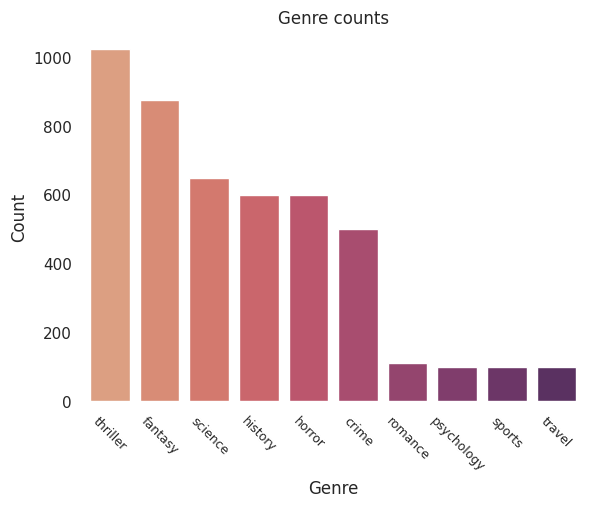

In [6]:
# Initialize the matplotlib figure
fig, ax = plt.subplots()

# Plot the data
sns.barplot(
    x = genre_counts.index,
    y = genre_counts,
    palette = 'flare'
)

# Add axis labels, make pretty
plt.title('Genre counts')
ax.set(
    xlabel = "Genre",
    ylabel = "Count"
)
ax.tick_params(axis='x', labelrotation=-45, labelsize=9)
sns.despine(left=True, bottom=True)

Text(0.5, 1.0, 'Genre percentages')

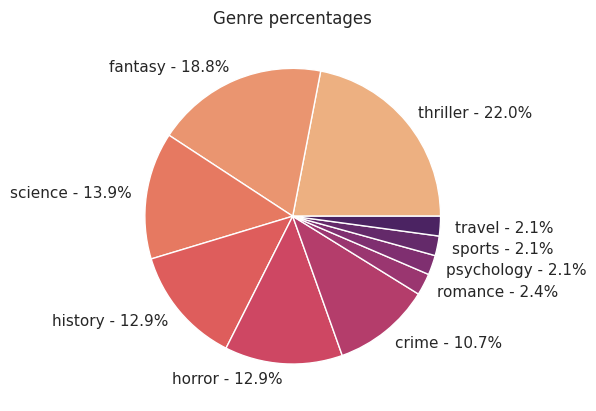

In [7]:
percentages = 100 * genre_counts / genre_counts.sum()
labels = [f"{x} - {y:.1f}%" for x,y in zip(genre_counts.index,percentages)]
colors = plt.get_cmap('flare')(np.linspace(0,1,len(percentages)))

plt.figure()

plt.pie(
    x=genre_counts,
    labels=labels,
    colors=colors
)

plt.title("Genre percentages")

# Text Preprocessing

- lowercase
- remove punctuation
- remove stopwords
- stemming/lemmatization
- combine title and summary into new column

In [8]:
# Create new column with combined title and summary
df['combined'] = df['title'] + '. ' + df['summary']

In [9]:
# create column with language info
df['lang'] = df['combined'].apply(
    lambda x:
    langdetect.detect(x)
        if x.strip() != ""
        else ""
    )

# only keep datapoints in English
df = df[df['lang']=='en']

In [10]:
nonsense_summaries_idx = [338, 588, 834, 1574, 1772, 2410, 2485]

for i in nonsense_summaries_idx:
    df = df.drop(i)

In [11]:
# Make everything lowercase
def lowercase(text):
    text = text.lower()
    return text

# Remove punctuation
def remove_punct(text):
    text = re.sub(r'[^\w\s]|_', '', text)
    return text

# Remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = ' '.join([w for w in text.split() if w not in stop_words])
    return text

# Lemmatize tokens
def get_lemmas(text):
    wnl = WordNetLemmatizer()
    text = ' '.join([wnl.lemmatize(w) for w in text.split()])
    return text

In [12]:
# Preprocessing
def preprocessing(text):
    text = lowercase(text)
    text = remove_punct(text)
    text = remove_stopwords(text)
    text = get_lemmas(text)
    return text

In [13]:
df['combined_clean'] = df['combined'].apply(preprocessing)

# Feature engineering
- number of characters (title/summary)
- number of words (title/summary)
- number of sentences (summary)
- number of unique words (summary)
- number of stopwords (title/summary)
- average word length (combined)
- average sentence length (summary)
- ratio of unique words to total number of words (combined)
- ratio of stopwords to total number of words (combined)
- sentiment analysis (TextBlob)
- count of recognized NER categories (e.g. PERSON, NORP, etc. w/ spaCy)

For each feature, look at bivariate distributions of these features across all genres. The histograms and densities (since sample sizes vary so much) allow us to see if a variable is predictive.

### Number of characters

We create two features that track character counts:
- **title\_char\_count**: the number of characters in the book title
- **summary\_char\_count**: the number of characters in the book summary

In [14]:
def char_count(text):
    return len(text)

df['title_char_count'] = df['title'].apply(char_count)
df['summary_char_count'] = df['summary'].apply(char_count)

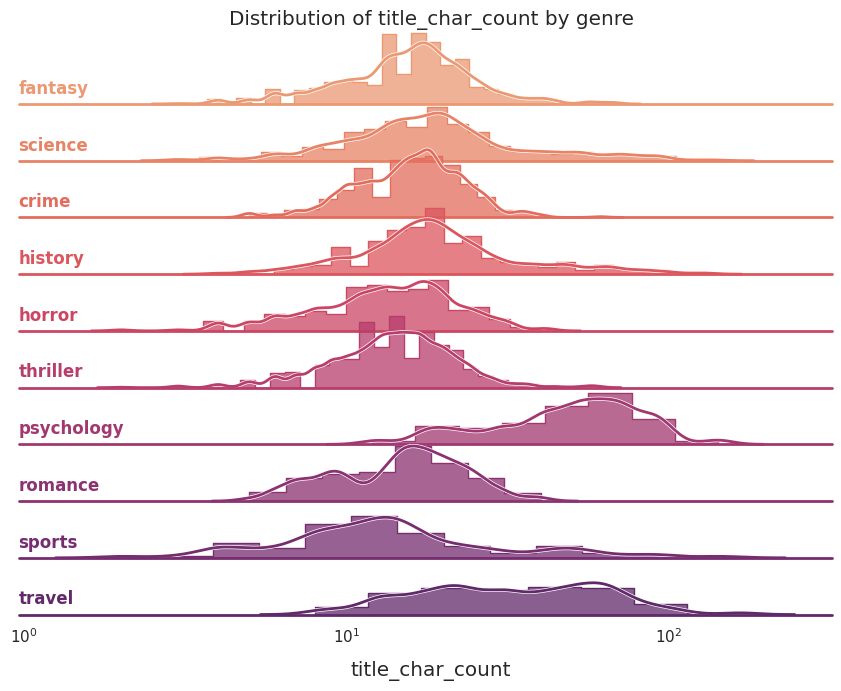

In [15]:
# TODO: use displot or histplot with kde=True in order to get
# histogram with kde overlaid
# TODO: use Pearson's first skewness coefficient (or mode skewness)
#     (mean - mode) / std_dev
# to quantify the skew and therefore justify the use of log scale
# Would it maybe be sufficient to place a dot/line at the mean of
# the distribution?
# scipy.stats.kurtosis and scipy.stats.skew
def feature_ridge_plot_by_genre(feature, log=True, bw=None, draw_kde=True, rlabels=False):
    # Initialize the FacetGrid object
    g = sns.FacetGrid(
            df, row='genre', hue='genre',
            aspect=13, height=0.7, palette='flare'
        )
    
    # Draw the densities
    #g.map(
    #    sns.kdeplot, feature, bw_adjust=.5,
    #    clip_on=False, fill=True, alpha=0.6,
    #    linewidth=1.5, log_scale=log
    #)
    # Create version with bigger (white) linewidth to create
    # visual separation between overlapping densities
    if draw_kde:
        g.map(sns.kdeplot, feature, bw_adjust=.5,
              clip_on=False, linewidth=3, color='w',
              log_scale=log
        )
        g.map(sns.kdeplot, feature, bw_adjust=.5,
              clip_on=False, linewidth=2, #color='w',
              log_scale=log
        )
    
    g.map(sns.histplot,feature,log_scale=log,stat='density',element='step',fill=True,binwidth=bw)

    # Draw reference line at y=0 for each facet
    # Passing color=None uses the hue mapping for the refline
    g.refline(y=0, linewidth=2, linestyle='-', color=None, clip_on=False)

    # Define and use a simple function to label the plot
    # in axes coordinates
    if rlabels:
        label_xpos = 1
        ha = 'right'
    else:
        label_xpos = 0
        ha='left'
    
    def label(x,color,label):
        ax = plt.gca()
        ax.text(label_xpos,.2,label,fontweight='bold',color=color,ha=ha,va='center',transform=ax.transAxes)  
    g.map(label, 'genre')

    #print(df.groupby("genre")['avg_sent_length'].apply(skew))
    #print(df.groupby('genre')['avg_sent_length'].apply(lambda x : kurtosis(x,fisher=True)))

    
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)
    
    # Remove extraneous axes details
    g.set_titles("")
    g.set(yticks=[],ylabel="",xlabel="")
    g.despine(bottom=True,left=True)
    
    # Set title and xlabel for the entire figure
    g.figure.suptitle(
        f"Distribution of {feature} by genre",
        verticalalignment='bottom',
        x=0.54, y=0.94
    )
    g.figure.supxlabel(feature, va='bottom', x=0.54)

feature_ridge_plot_by_genre('title_char_count')

In [16]:
def feature_density_by_genre(feature, log=True):
    fig, ax = plt.subplots()

    sns.kdeplot(
        data=df,
        x=feature,
        hue='genre',
        palette='colorblind',
        common_norm=False,
        log_scale=log
    )
    
    sns.despine()

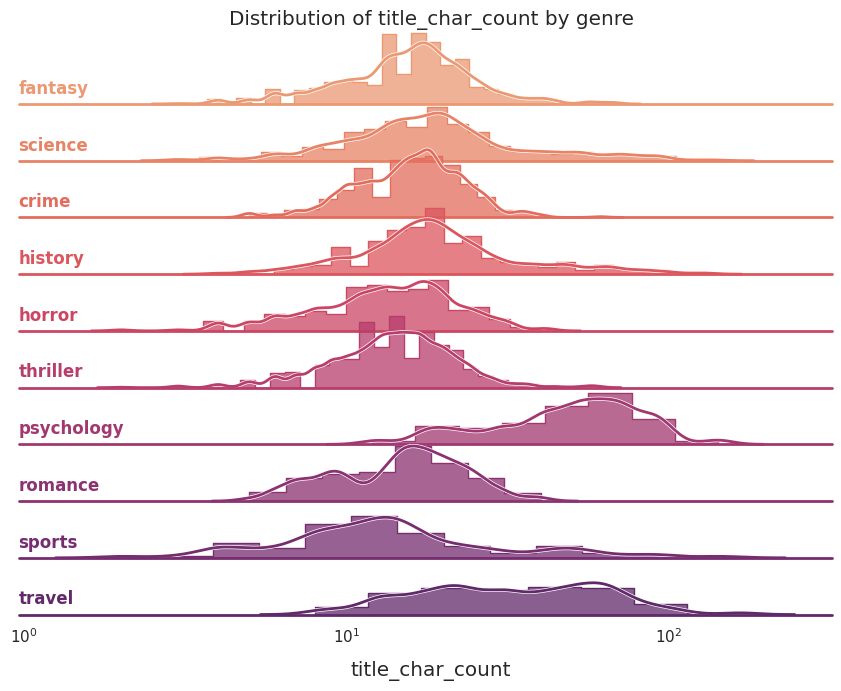

In [17]:
#feature_density_by_genre('title_char_count')
feature_ridge_plot_by_genre('title_char_count')

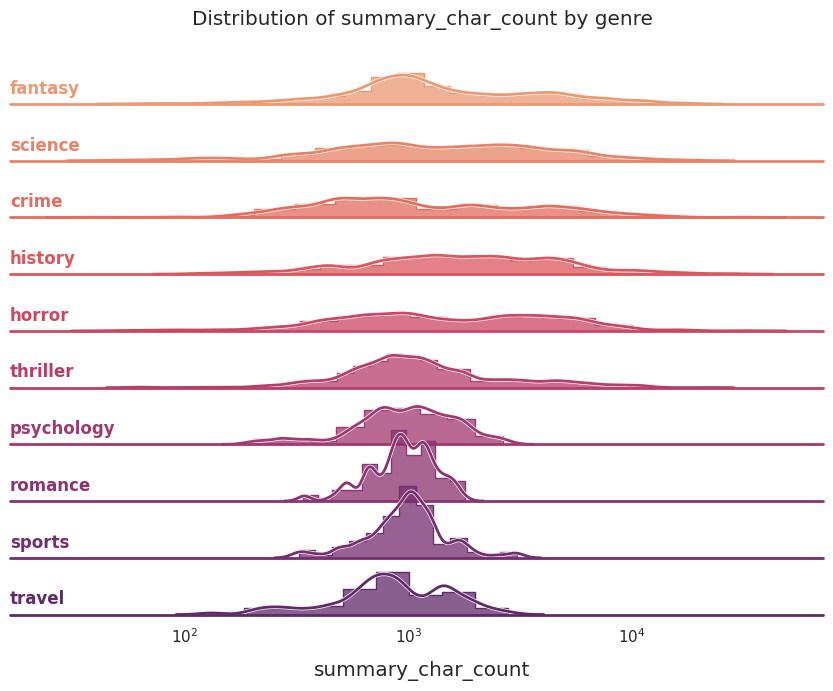

In [18]:
#feature_density_by_genre('summary_char_count')
feature_ridge_plot_by_genre('summary_char_count')

### Number of words
- **title\_word\_count**: the number of words in the book title
- **summary\_word\_count**: the number of words in the book summary

In [19]:
def word_count(text):
    return len(text.split())

df['title_word_count'] = df['title'].apply(word_count)
df['summary_word_count'] = df['summary'].apply(word_count)

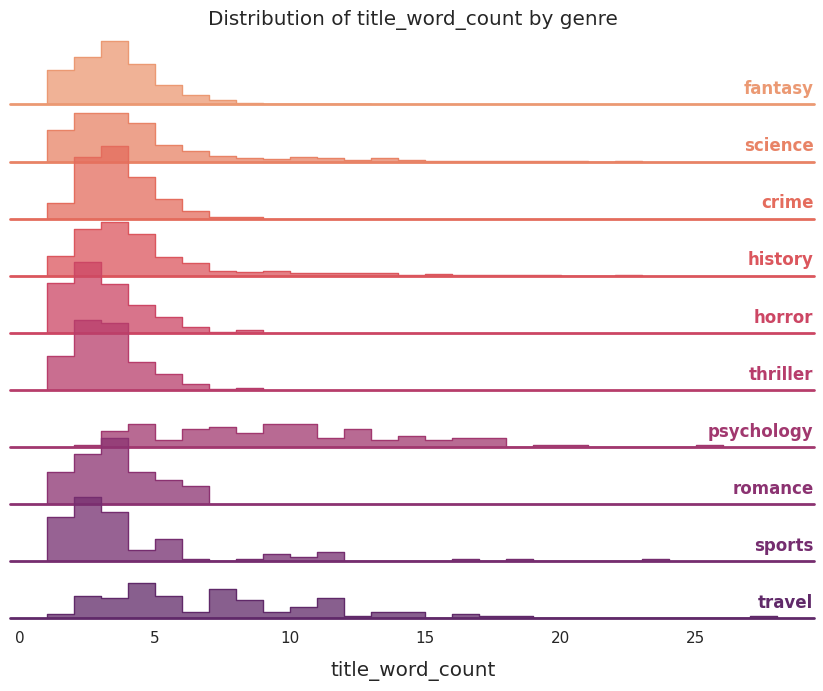

In [20]:
feature_ridge_plot_by_genre('title_word_count',log=False, bw=1, draw_kde=False, rlabels=True)

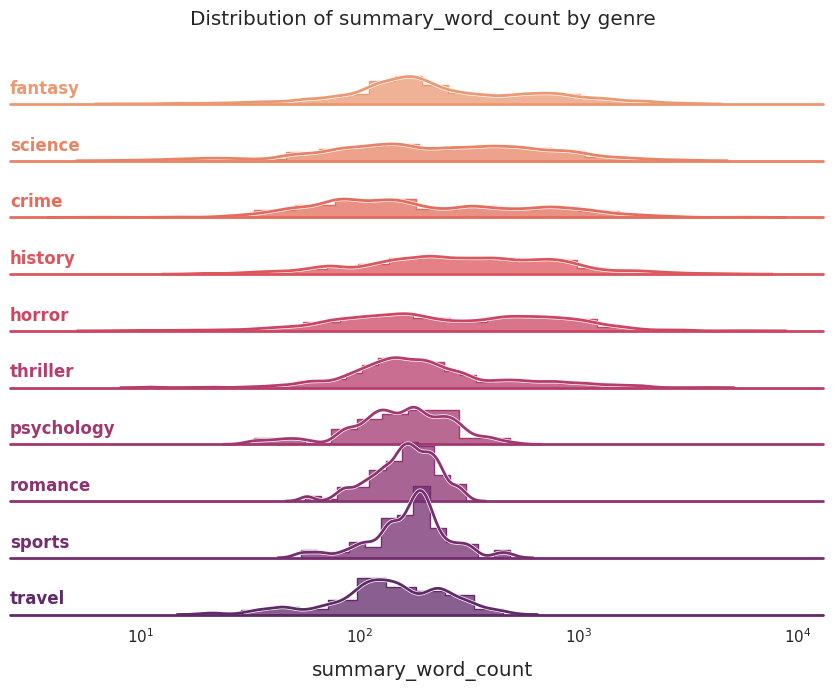

In [21]:
feature_ridge_plot_by_genre('summary_word_count')

### Number of sentences
- **sent_count**: the number of sentences in the summary

**NB**: doesn't make sense to talk about the number of sentences in the title, since they're so often short fragments and not full sentences

In [22]:
def sent_count(text):
    return len(sent_tokenize(text))

df['sent_count'] = df['summary'].apply(sent_count)

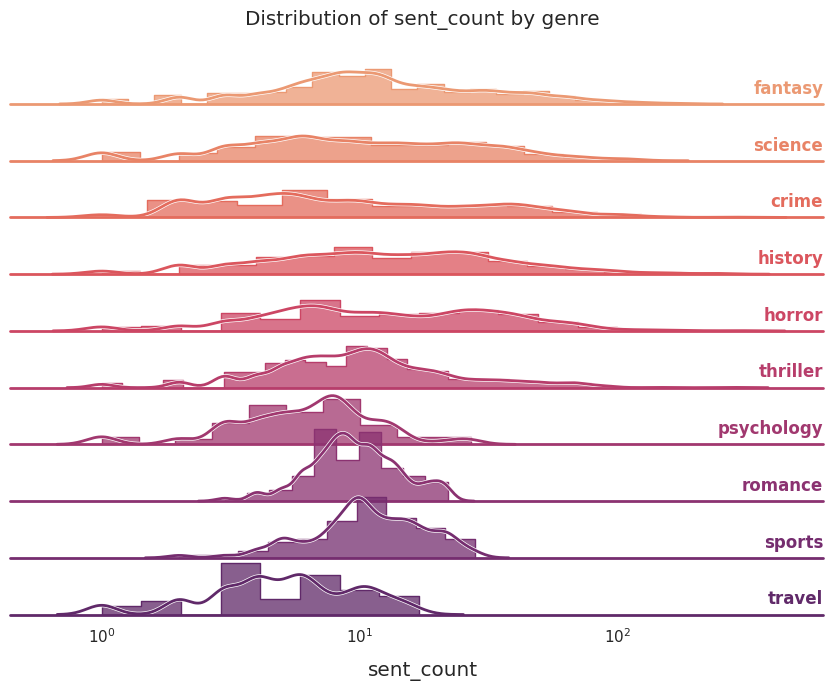

In [23]:
feature_ridge_plot_by_genre('sent_count',rlabels=True)

### Specific word counts
- **unique\_word\_count**: the number of unique words in the combined book title and summary
    - use combined here because the summary often contains the title itself
- **title\_stopword\_count**: the number of stopwords in the book title
- **summary\_stopword\_count**: the number of stopwords in the book summary

In [24]:
def unique_word_count(text):
    return len(set(remove_punct(text).split(' ')))
    
df['unique_word_count'] = df['combined'].apply(unique_word_count)

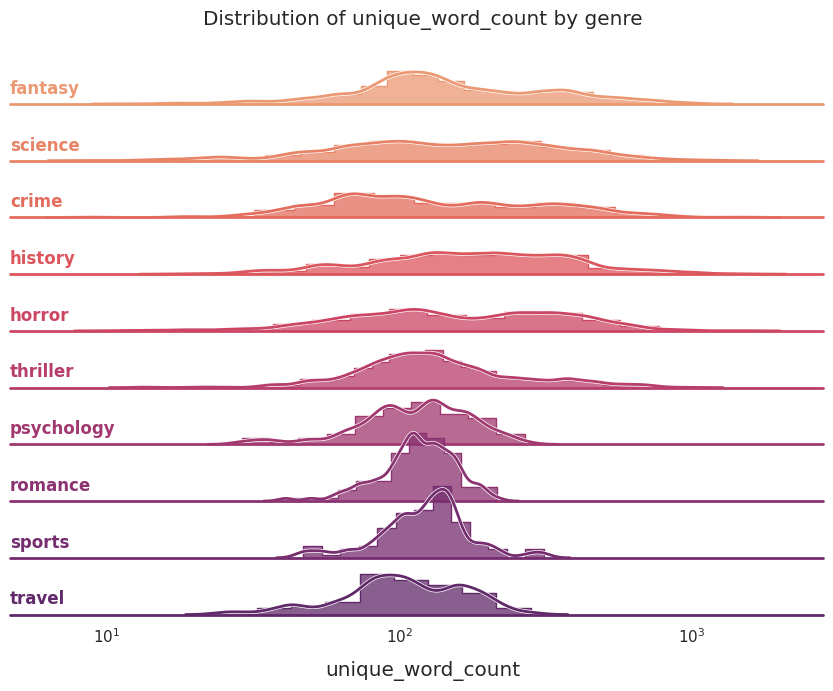

In [25]:
feature_ridge_plot_by_genre('unique_word_count')

In [26]:
def stopword_count(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = remove_punct(text)
    stopwords_in_text = [w for w in text.split() if w in stop_words]
    return len(stopwords_in_text)

df['title_stopword_count'] = df['title'].apply(stopword_count)
df['summary_stopword_count'] = df['summary'].apply(stopword_count)

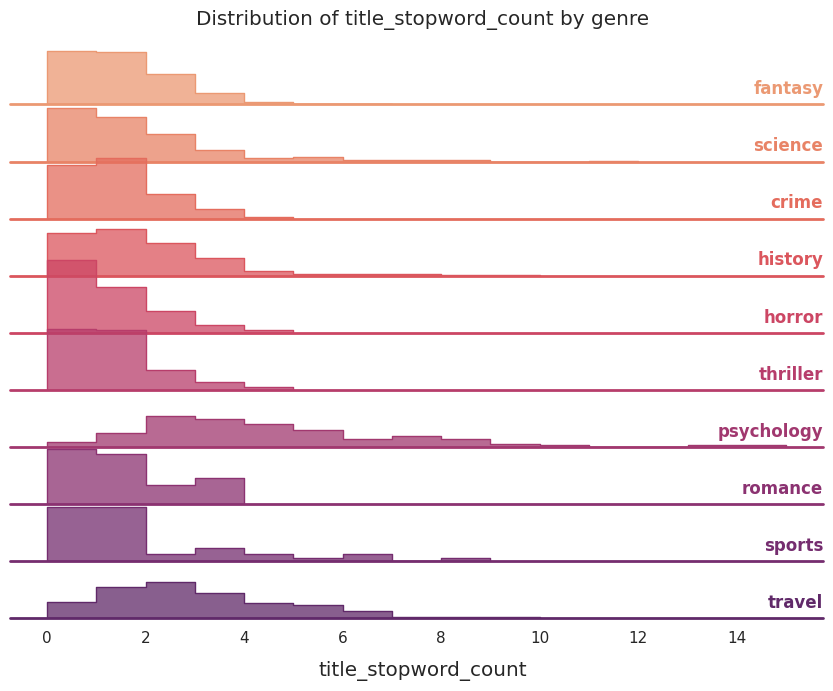

In [28]:
feature_ridge_plot_by_genre('title_stopword_count',log=False,draw_kde=False,bw=1,rlabels=True)

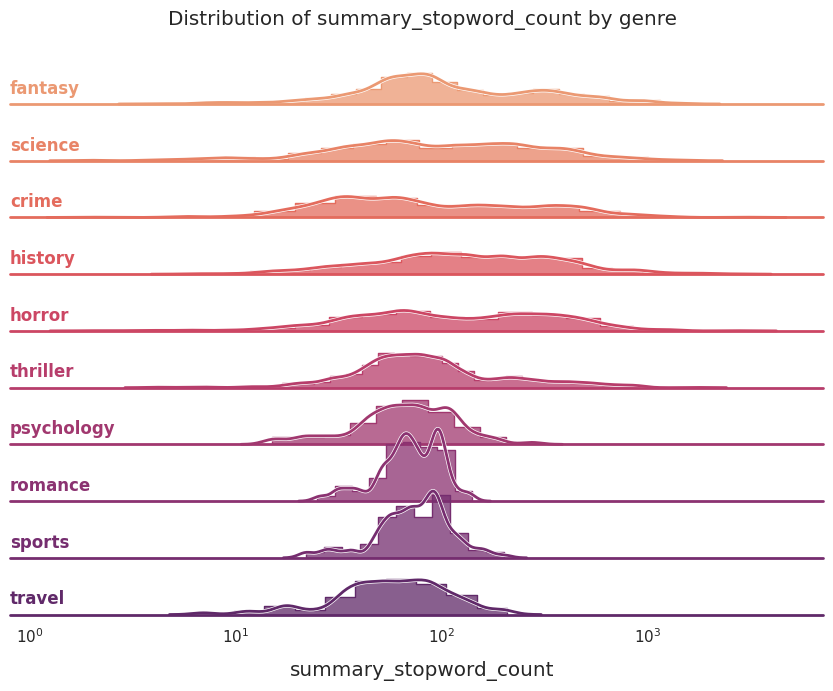

In [32]:
feature_ridge_plot_by_genre('summary_stopword_count')

### Averages
- **title\_avg\_word\_length**: the average number of characters per word in book title
- **summary\_avg\_word\_length**: the average number of characters per word in book summary
- **avg\_sent\_length**: the average number of words per sentence in book summary

In [33]:
df['title_avg_word_length'] = df['title_char_count'] / df['title_word_count']
df['summary_avg_word_length'] = df['summary_char_count'] / df['summary_word_count']

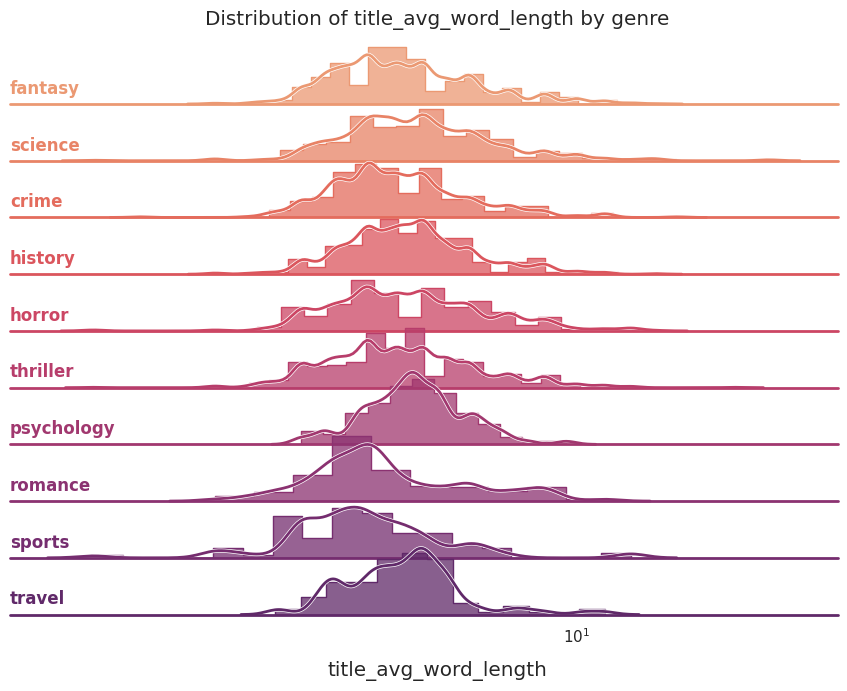

In [40]:
feature_ridge_plot_by_genre('title_avg_word_length')

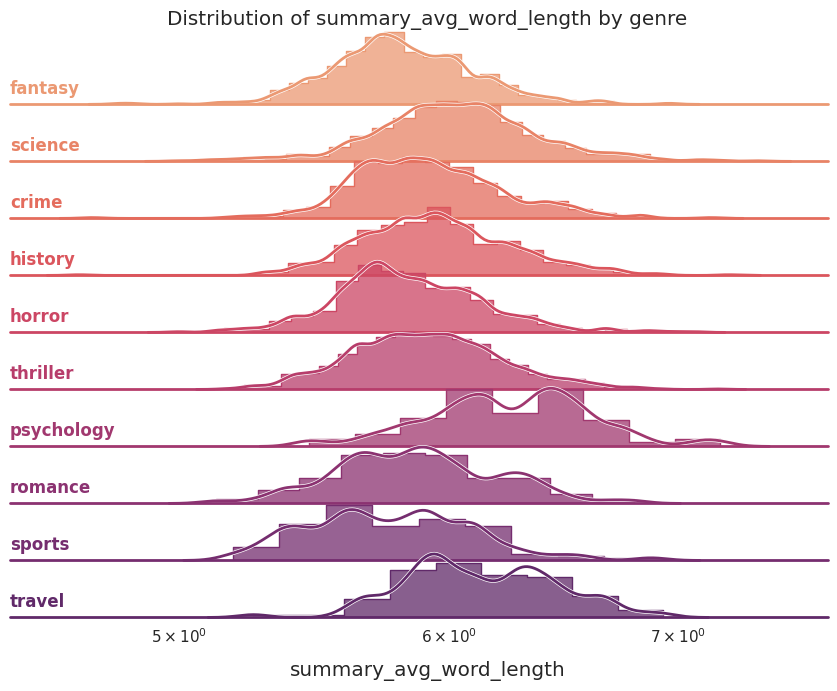

In [38]:
feature_ridge_plot_by_genre('summary_avg_word_length')

In [36]:
df['avg_sent_length'] = df['summary_word_count'] / df['sent_count']

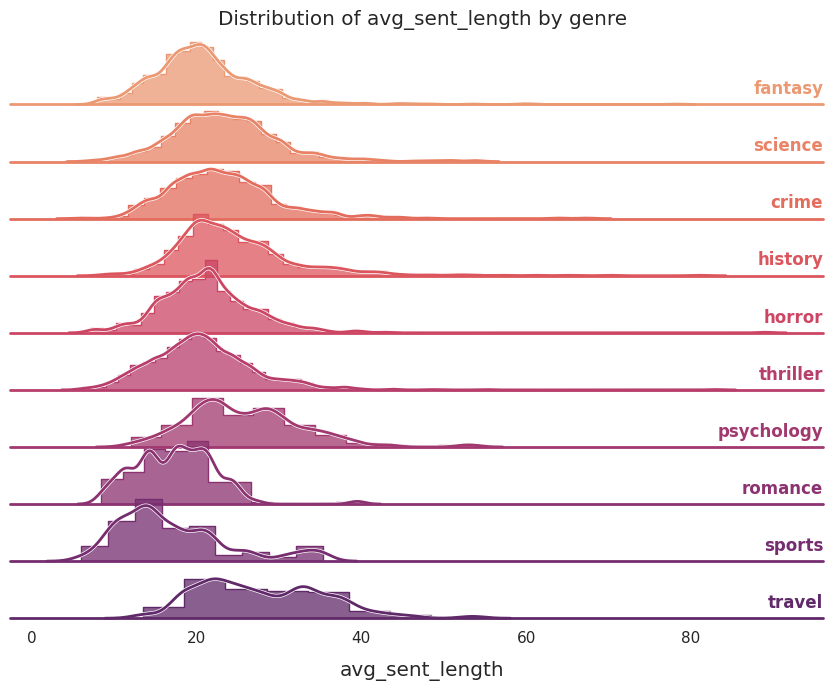

In [37]:
feature_ridge_plot_by_genre('avg_sent_length', log=False,rlabels=True)

In [ ]:
from scipy.stats import skew, kurtosis
print(df.groupby("genre")['avg_sent_length'].apply(skew))
print(df.groupby('genre')['avg_sent_length'].apply(lambda x : kurtosis(x,fisher=True)))
print(skew(df['title_stopword_count']))
print(kurtosis(df['title_stopword_count'],fisher=True))

## Sentiment Analysis

In [41]:
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['combined'].apply(
    lambda x :
    sia.polarity_scores(x)['compound']
    )

Text(0.02, 0.55, 'Density')

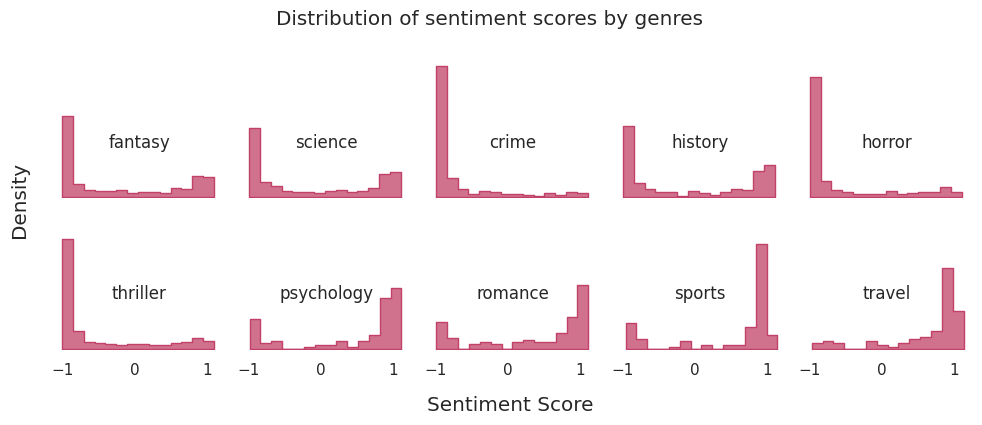

In [219]:
g = sns.FacetGrid(df, col='genre', col_wrap=5, height=2, palette='flare', margin_titles=True)

g.map_dataframe(sns.histplot,
                x='sentiment_score',
                color = plt.cm.get_cmap('flare')(0.5),
                binwidth=0.15,
                stat='density',
                fill=True,
                element='step') 

# Adjust space between subplots
g.figure.subplots_adjust(hspace=0.1,wspace=0.1)
   
# Set subplot titles
for col_val, ax in g.axes_dict.items():
    ax.text(.5,.4,f"{col_val}",ha='center',va='center',transform=ax.transAxes)
    
# Get rid of extraneous axis decorations
g.set_titles("")
g.set(yticks=[],ylabel="",xticks=[-1,0,1],xlabel="")
g.despine(bottom=True,left=True)
    
# Set title and axis labels for the entire figure
g.figure.suptitle(
    "Distribution of sentiment scores by genres",
    verticalalignment='center',
    x=0.5, y=1
)
g.figure.supxlabel("Sentiment Score", va='bottom', x=0.52)
g.figure.supylabel("Density",va='center',ha='left',y=0.55)

## Named-Entity Recognition (NER)

In [224]:
## call model
ner = spacy.load("en_core_web_lg")

txt = df['combined'].iloc[0]
doc = ner(txt)

spacy.displacy.render(doc, style='ent')